In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl
from scipy.optimize import minimize
from config import pmlb_dir as parent_dir

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)
folders = os.listdir(parent_dir)
print(folders)

['pmlb7', 'pmlb12', 'pmlb18', 'pmlb20', 'pmlb27', 'pmlb15', 'pmlb0', 'pmlb4', 'pmlb11', 'pmlb23', 'pmlb24', 'pmlb16', 'pmlb3', 'pmlb9', 'pmlb1', 'pmlb26', 'pmlb14', 'pmlb19', 'pmlb13', 'pmlb21', 'pmlb6', 'pmlb8', 'pmlb2', 'pmlb25', 'pmlb17', 'pmlb10', 'pmlb22', 'pmlb5']


# load results from a directory
**This notebook analyzes the output produced by running submit_jobs.py. Note - this script aggregates results - needs to be done to average across trials to make double descent curves**

In [ ]:
# !rm dir/*/*processed*
!python postprocess.py

# figures

In [2]:
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

LABS = {
    'mdl_m10.0': 'MDL-COMP',
    'mdl_m1-1.0': 'MDL-COMP',
    'mdl_m1-5.0': 'MDL-COMP',    
    'ridge-1.0': 'Ridge-CV',
    'ridge-5.0': 'Ridge-CV',    
    'mdl_orig0.0': 'MDL-COMP-ORIG',
    'ols0.0': 'OLS'
}

**generate curves showing pmlb for each of the datasets**

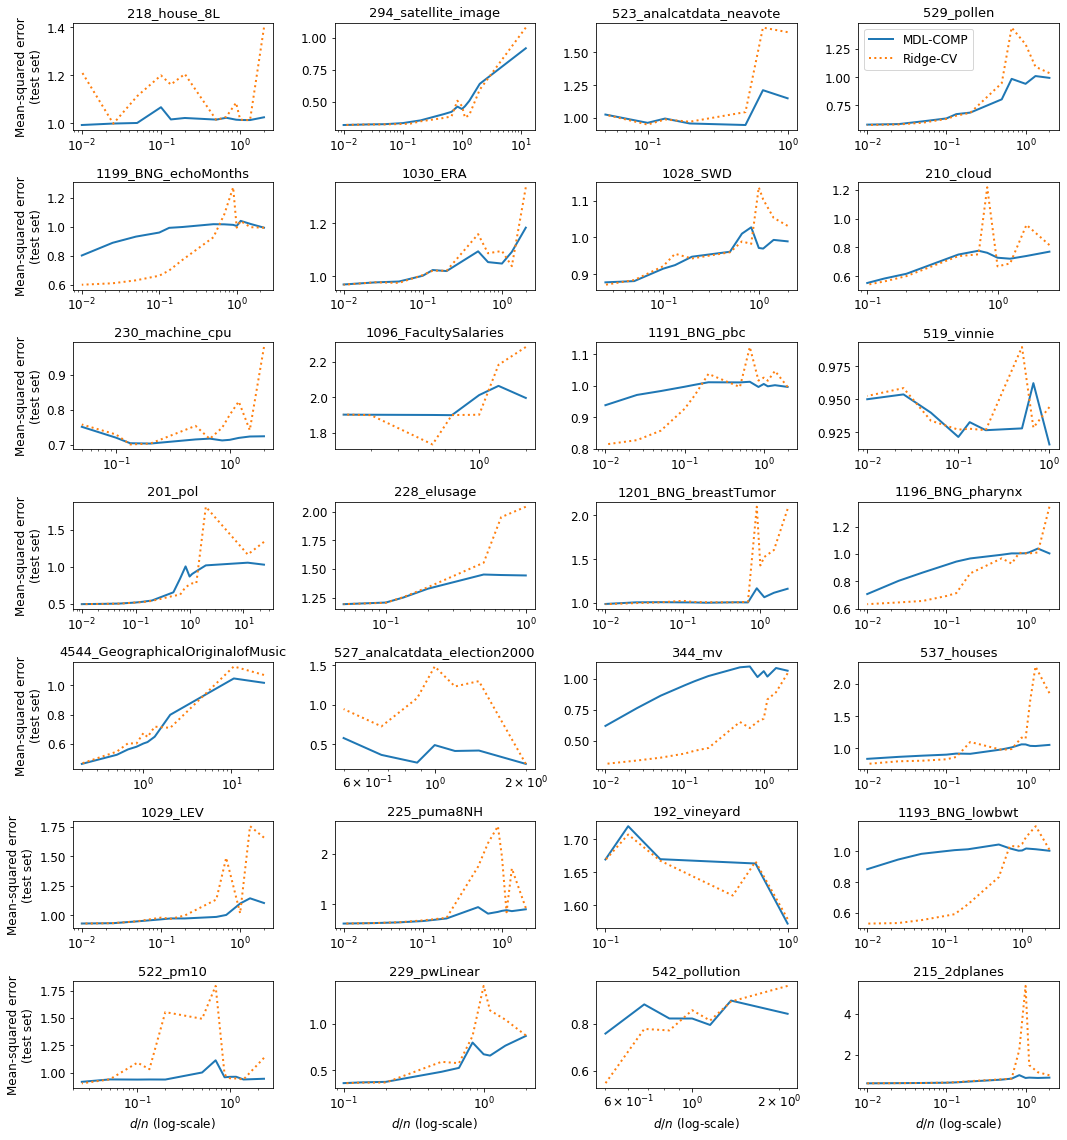

In [11]:
dfs_list = []
dsets = []
plot_all = False
R, C = 7, 4
# lets = ['A', 'B', 'C', 'D', 'E']
titles = {
    't': 'T-Distribution',
    'thresh': 'Thresholds',
    'decay': 'Decaying eigenvalues'
}
fig = plt.figure(figsize=(15, 16))
j = 0
for folder in folders: #, 'clustered', 'gaussian_scale_var']):
#     plt.title(lets[j], fontweight='bold', loc='left')    
    out_dir = oj(parent_dir, folder)
    df = pd.read_pickle(oj(out_dir, 'processed.pkl')).reset_index()
    dfs_list.append(df)
    dset_name = df['dset_name'].values[0]
    if dset_name not in data.REGRESSION_DSETS_LARGE_NAMES_RECOGNIZABLE:
        continue
    plt.subplot(R, C, j + 1)
#     plt.axhline(df.mse_zero.values[0], lw=4, color='gray', alpha=0.4, label='trivial')
    for i in range(df.shape[0]):
        curve = df.iloc[i]
    
        if curve.model_type == 'ridge' and curve.reg_param > 0:
            continue
        if curve.model_type == 'ols':
            continue
        l = str(curve.model_type) + str(curve.reg_param)
            

        if 'mdl' in curve.model_type:
            ls = '-'
        else:
            ls = ':'
        
        kwargs = {'label': LABS[l], 'alpha': 1, 'lw': 2, 'linestyle': ls}

    #     plt.plot(curve.ratio, curve.mse_test, 
        plt.plot(curve.ratio, curve.mse_test, **kwargs) #np.square(curve.bias) + curve['var'], **kwargs)
    if j % C == 0:
        plt.ylabel('Mean-squared error\n(test set)')
    if j >= C * (R - 1):
        plt.xlabel('$d/n$ (log-scale)') #, fontsize=20)
    plt.xscale('log')
#     plt.yscale('log')

#     s = f'{model_type}_{dset}_{dset_name}+p={num_features}+lambda={reg_param}+noise_mult={noise_mult}'
    if j == C - 1:
        plt.legend()
    
    plt.title(dset_name, fontsize=13)
#     plt.axis('off')
    j += 1

plt.tight_layout()
# plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.savefig(oj(save_dir, 'fig_pmlb_curves.pdf'))
# plt.show()

num satisfactory dsets 19


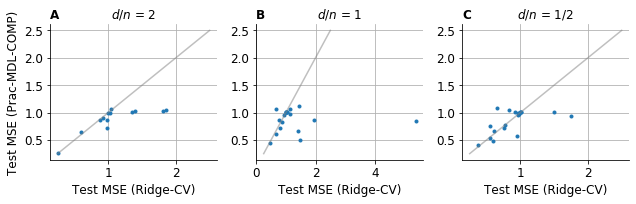

In [6]:
df_all_full = pd.concat(dfs_list)
ratios = [2, 1, 1/2]
for ratio in ratios:
    def get_mse(row):
    #     print(row['ratio'], row['mse_test'])
        idxs = np.where(row['ratio']==ratio)[0]
        if len(idxs) == 0:
            return np.nan
        return row['mse_test'][idxs[0]]
    df_all_full[f'mse_{ratio:.2f}'] = df_all_full.apply(get_mse, axis=1)
df_all = df_all_full[df_all_full['num_features'] >= 6] # remove this to see the really small datasets
print('num satisfactory dsets', int(df_all.shape[0]/3))

R, C = 1, 3
titles = ['2', '1', '1/2']
plt.figure(figsize=(9, 3))
lets = ['A', 'B', 'C']
for c in range(3):
    k = f'mse_{ratios[c]:.2f}'
    ax = plt.subplot(R, C, c + 1)
    plt.title(lets[c], loc='left', fontweight='bold')
    plt.plot(df_all[df_all['model_type']=='ridge'][k],
             df_all[df_all['model_type']=='mdl_m1'][k], '.')
    plt.xlabel('Test MSE (Ridge-CV)')
    plt.title('$d/n$ = ' + titles[c])
    if c == 0:
        plt.ylabel('Test MSE (Prac-MDL-COMP)')
    plt.plot([0.25, 2.5], [0.25, 2.5], color='gray', alpha=0.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    plt.grid()
plt.tight_layout()
plt.savefig(oj(save_dir, 'fig_pmlb.pdf'))
plt.show()

# dataset statistics

**omit small dsets**

In [19]:
n_trains = []
n_feats = []
dset_names = sorted(df_all_full.dset_name.unique())
for name in tqdm(dset_names):
    dat = pmlb.fetch_data(name)
    n_trains.append(dat.shape[0])
    n_feats.append(dat.shape[1])

100%|██████████| 28/28 [00:27<00:00,  1.38it/s]


In [ ]:
dd = df_all_full.sort_values('dset_name')
table = pd.DataFrame.from_dict({
    'Dataset name (OpenML ID)': dset_names,
    'Number of instances': n_trains,
    'Number of features': n_feats,
    'Ridge-CV MSE, $d/n=1$' : dd[dd.model_type.str.contains('ridge')]['mse_1.00'],
    'MDL-COMP MSE, $d/n=1$': vals,#dd[dd.model_type.str.contains('mdl_m1')]['mse_1.00']
})
print(table.to_latex(index=False))